label
2    2634124
3     486504
1    4000013
4     317183
0    1098195
Name: count, dtype: int64


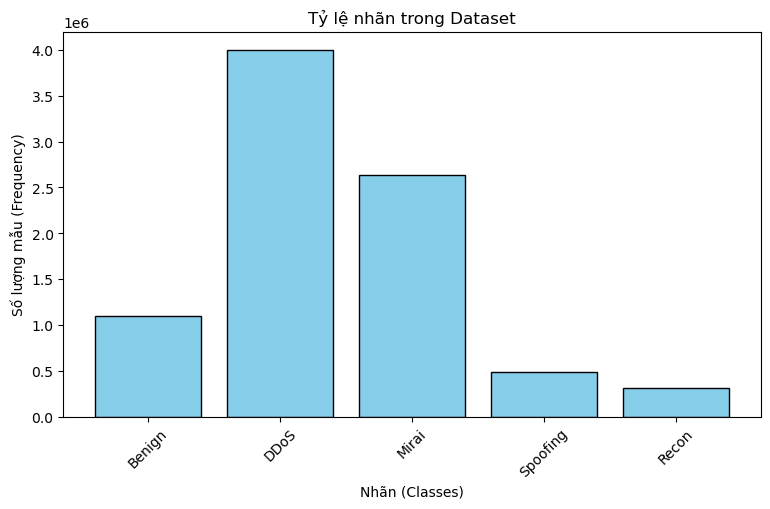

In [12]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers, callbacks

file_path = "scaled_output_parquet"
#file_path = "scaled_output_parquet"

#df = dk.read_csv(file_path)
df = dk.read_parquet(file_path)
import matplotlib.pyplot as plt
# Đếm số lượng mỗi nhãn

label_counts = df['label'].value_counts().compute()
print(label_counts)

ordered_labels = [0,1,2,3,4]
ordered_counts = [label_counts.get(label,0) for label in ordered_labels]

labels = ["Benign", "DDoS", "Mirai", "Spoofing", "Recon"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, ordered_counts, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [13]:
"""
Kiểm tra dataset sau khi xử lý
"""
#df = dk.read_csv("single_file.csv")

# Tính tổng số mẫu
total_samples = df.shape[0].compute()
print(f"Tổng số mẫu: {total_samples}")
    
# Tính phân bố label
print("Phân bố label:")
print(label_counts.sort_index())
    
# Kiểm tra số lượng label liên tiếp
df_small = df.head(8000000)
labels = df_small['label'].values
max_consecutive = current = 1  

for i in range(1, len(labels)):
    if labels[i] == labels[i-1]:
        current += 1
        max_consecutive = max(max_consecutive, current)
    else:
        current = 1  # Reset bộ đếm khi label thay đổi

print(f"Chuỗi liên tiếp dài nhất trong 11 triệu mẫu đầu: {max_consecutive}")


Tổng số mẫu: 8536019
Phân bố label:
label
0    1098195
1    4000013
2    2634124
3     486504
4     317183
Name: count, dtype: int64
Chuỗi liên tiếp dài nhất trong 11 triệu mẫu đầu: 1685


In [2]:
#Global var 
batch_size = 512
ratio_test_all = 0.20

from monitor import ResourceMonitor
monitor = ResourceMonitor(interval=1, gpu_id=0)
monitor.start()
from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
'''
def standardize_dask_df(dask_df):
    scaler = StandardScaler()
    X = dask_df.drop(columns=['label']).compute().values
    scaler.fit(X)
    for part in dask_df.to_delayed():
        part = part.compute()
        if part.empty:
            continue
        X_part = part.drop(columns=['label']).values
        X_scaled = scaler.transform(X_part)
        part.iloc[:, :-1] = X_scaled
        yield part

scaled_parts = list(standardize_dask_df(df))
scaled_df = dk.from_pandas(pd.concat(scaled_parts), npartitions=df.npartitions)
scaled_df.to_csv("scaled_output.csv", single_file=True, index=False)
print("Đã in thành công")
'''
train_df, val_test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.85, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)
    

Giám sát GPU 0 đã được kích hoạt.
>> Bắt đầu giám sát tài nguyên...


In [3]:
train_gen = dask_to_tf_dataset(train_df, 512).repeat()
test_gen = dask_to_tf_dataset(test_df, 512)
val_gen = dask_to_tf_dataset(val_df, 512).repeat()

I0000 00:00:1751889525.150957  263701 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
import math
n_samples =  np.ceil(train_df.shape[0])
steps_per_epoch = int(n_samples / (batch_size))
validation_steps = int(steps_per_epoch / (16))
print("Steps/Epoch: ", steps_per_epoch)
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

Steps/Epoch:  13337
Batch test:  2834


In [5]:
from datetime import datetime, timedelta
import sys, os
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras

start_time = datetime.now()

model = keras.Sequential([
    layers.Input(shape=input_shape),
    #layers.Conv1D(filters=32, kernel_size=7, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.5), 
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')
])
adam_optimizer = optimizers.Adam(learning_rate=1e-4)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Theo dõi loss trên tập validation
    patience=5,          # Dừng sau 5 epoch nếu không cải thiện
    restore_best_weights=True
)
model.compile(optimizer= adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import CSVLogger
os.makedirs("log_mono", exist_ok=True)
log_name = "log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv"
csv_logger = CSVLogger(log_name , append=True)
model.fit(train_gen, epochs=50, validation_data=val_gen, validation_steps= validation_steps , steps_per_epoch= steps_per_epoch, verbose = 1, callbacks=[early_stopping, csv_logger])

print("Đang dừng giám sát và lưu kết quả tài nguyên...")

resource_df = monitor.stop()
end_time = datetime.now()
simulated_time = end_time - start_time
model_name = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
# Lưu mô hình
model.save(model_name)

resource_usage = os.path.join("log_mono/", f"resource_usage_{datetime.now().strftime('%Hh%Mp__%d-%m-%Y')}.csv")
resource_df.to_csv(resource_usage, index=False)
print(f"Đã lưu kết quả giám sát tài nguyên vào file: {resource_usage}")


print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        94,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,621 (373.52 KB)

 Trainable params: 95,365 (372.52 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50


I0000 00:00:1751889536.724856  263791 service.cc:152] XLA service 0x7fc08800a0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751889536.724936  263791 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-07 18:58:56.752977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751889536.870774  263791 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-07 18:58:57.812005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961_0', 164 bytes spill stores, 164 bytes spill loads

2025-07-07 18:58:57.899199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

   67/13337 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.3468 - loss: 1.7991

I0000 00:00:1751889540.530667  263791 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  115/13337 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.3999 - loss: 1.6611

2025-07-07 18:59:01.859335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961_0', 20 bytes spill stores, 20 bytes spill loads

2025-07-07 18:59:01.934599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 28 bytes spill stores, 28 bytes spill loads

2025-07-07 18:59:01.999090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 80 bytes spill stores, 80 bytes spill loads

2025-07-07 18:59:02.085250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 660 bytes spill stores, 660 bytes spill loads



  779/13337 ━━━━━━━━━━━━━━━━━━━━ 1:15 6ms/step - accuracy: 0.5961 - loss: 1.1504

2025-07-07 18:59:06.104854: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 172 bytes spill stores, 172 bytes spill loads

2025-07-07 18:59:06.182520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 100 bytes spill stores, 100 bytes spill loads

2025-07-07 18:59:06.386560: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 1004 bytes spill stores, 1004 bytes spill loads

2025-07-07 18:59:06.445433: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_961', 292 bytes spill stores, 292 bytes spill loads

2025-07-07 18:59:06.492286: I exte

13337/13337 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.8729 - loss: 0.4166 - val_accuracy: 0.9553 - val_loss: 0.1369
Epoch 2/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9545 - loss: 0.1170 - val_accuracy: 0.9566 - val_loss: 0.1255
Epoch 3/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9563 - loss: 0.1100 - val_accuracy: 0.9576 - val_loss: 0.1166
Epoch 4/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9570 - loss: 0.1077 - val_accuracy: 0.9586 - val_loss: 0.1112
Epoch 5/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9574 - loss: 0.1062 - val_accuracy: 0.9589 - val_loss: 0.1037
Epoch 6/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9580 - loss: 0.1051 - val_accuracy: 0.9594 - val_loss: 0.1048
Epoch 7/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9583 - loss: 0.1038 - val_accuracy: 0.9594 - val_loss: 0.0987
Epoch 8/50
13337/13337 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9585 - lo

In [6]:
from tensorflow.keras.models import load_model
#model_name = "saved_model/cnn_model_2-0_batch512_11h59p__27-05-2025.keras"
model = load_model(model_name)

output = model.evaluate(test_gen, steps = num_batches_test)
print(f'Loss: {output[0]} Acc: {output[1]}')

2834/2834 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9628 - loss: 0.0913
Loss: 0.0917581096291542 Acc: 0.9627377986907959


2025-07-07 19:24:17.915994: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-07 19:24:17.916065: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-07-07 19:24:17.916070: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15881541706064493335
2025-07-07 19:24:17.916086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5812566903427845408
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function wh

Số lượng mẫu y_true_all: 1450586
Số lượng mẫu y_pred_all: 1450586
Precision: 0.8982877849026691
Recall: 0.8587270439188555
F1-Score: 0.8744034579139914


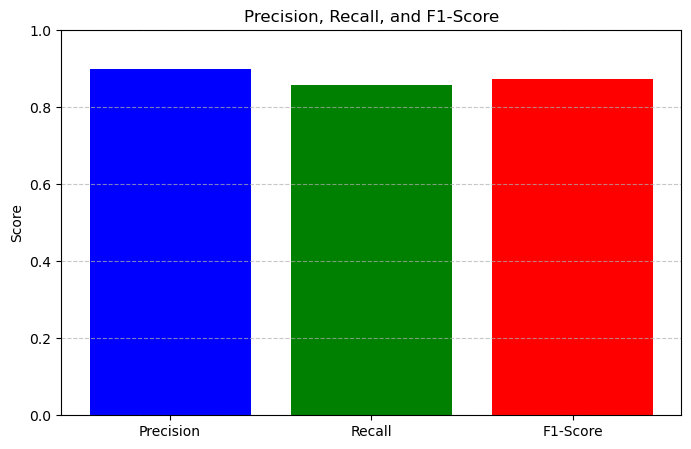

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình
model = load_model(model_name)

# Khởi tạo danh sách để lưu nhãn thực tế và nhãn dự đoán
y_true_all = []
y_pred_all = []

# Lặp qua các batch trong test_gen
for X_batch, y_batch in test_gen.take(num_batches_test):
    # Chuyển nhãn thực tế thành danh sách và làm phẳng
    y_true = y_batch.numpy()
    if len(y_true.shape) > 1:  # Nếu y_batch có dạng (batch_size, num_classes)
        y_true = np.argmax(y_true, axis=1)  # Chuyển từ one-hot hoặc xác suất thành nhãn
    else:
        y_true = y_true.flatten()  # Đảm bảo làm phẳng nếu cần
    y_true_all.extend(y_true)

    # Dự đoán với mô hình
    y_pred_prob = model.predict(X_batch, verbose=0)
    # Chuyển xác suất thành nhãn bằng argmax (cho phân loại đa lớp)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_pred_all.extend(y_pred)

# Kiểm tra số lượng mẫu
print("Số lượng mẫu y_true_all:", len(y_true_all))
print("Số lượng mẫu y_pred_all:", len(y_pred_all))

# Tính các chỉ số đánh giá
precision = precision_score(y_true_all, y_pred_all, average='macro')
recall = recall_score(y_true_all, y_pred_all, average='macro')
f1 = f1_score(y_true_all, y_pred_all, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Vẽ biểu đồ
param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

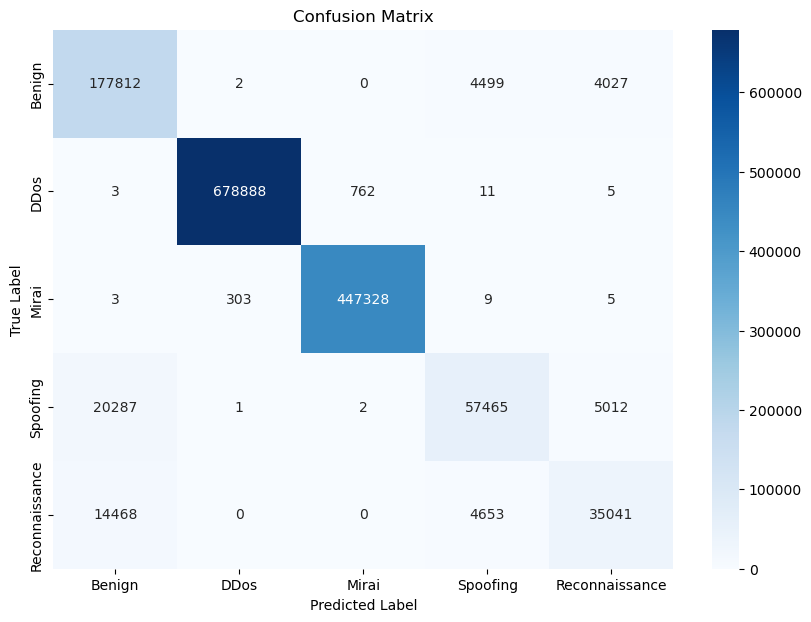

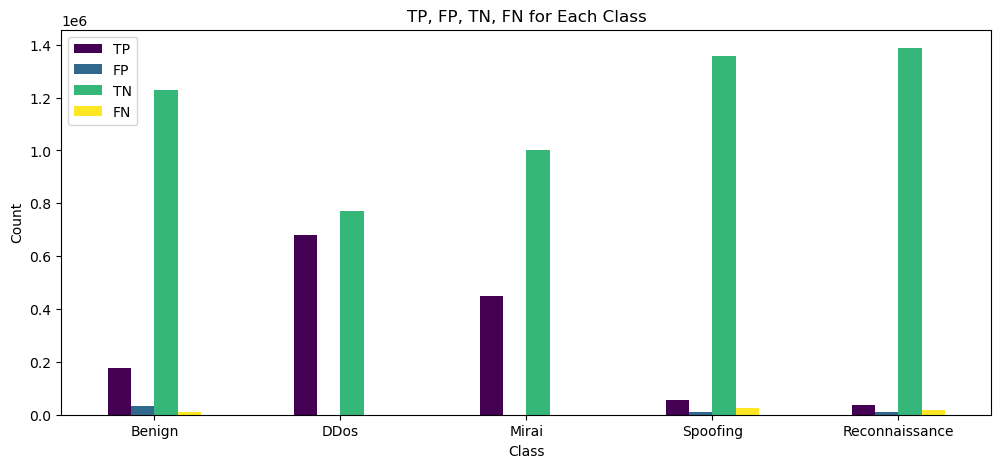

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

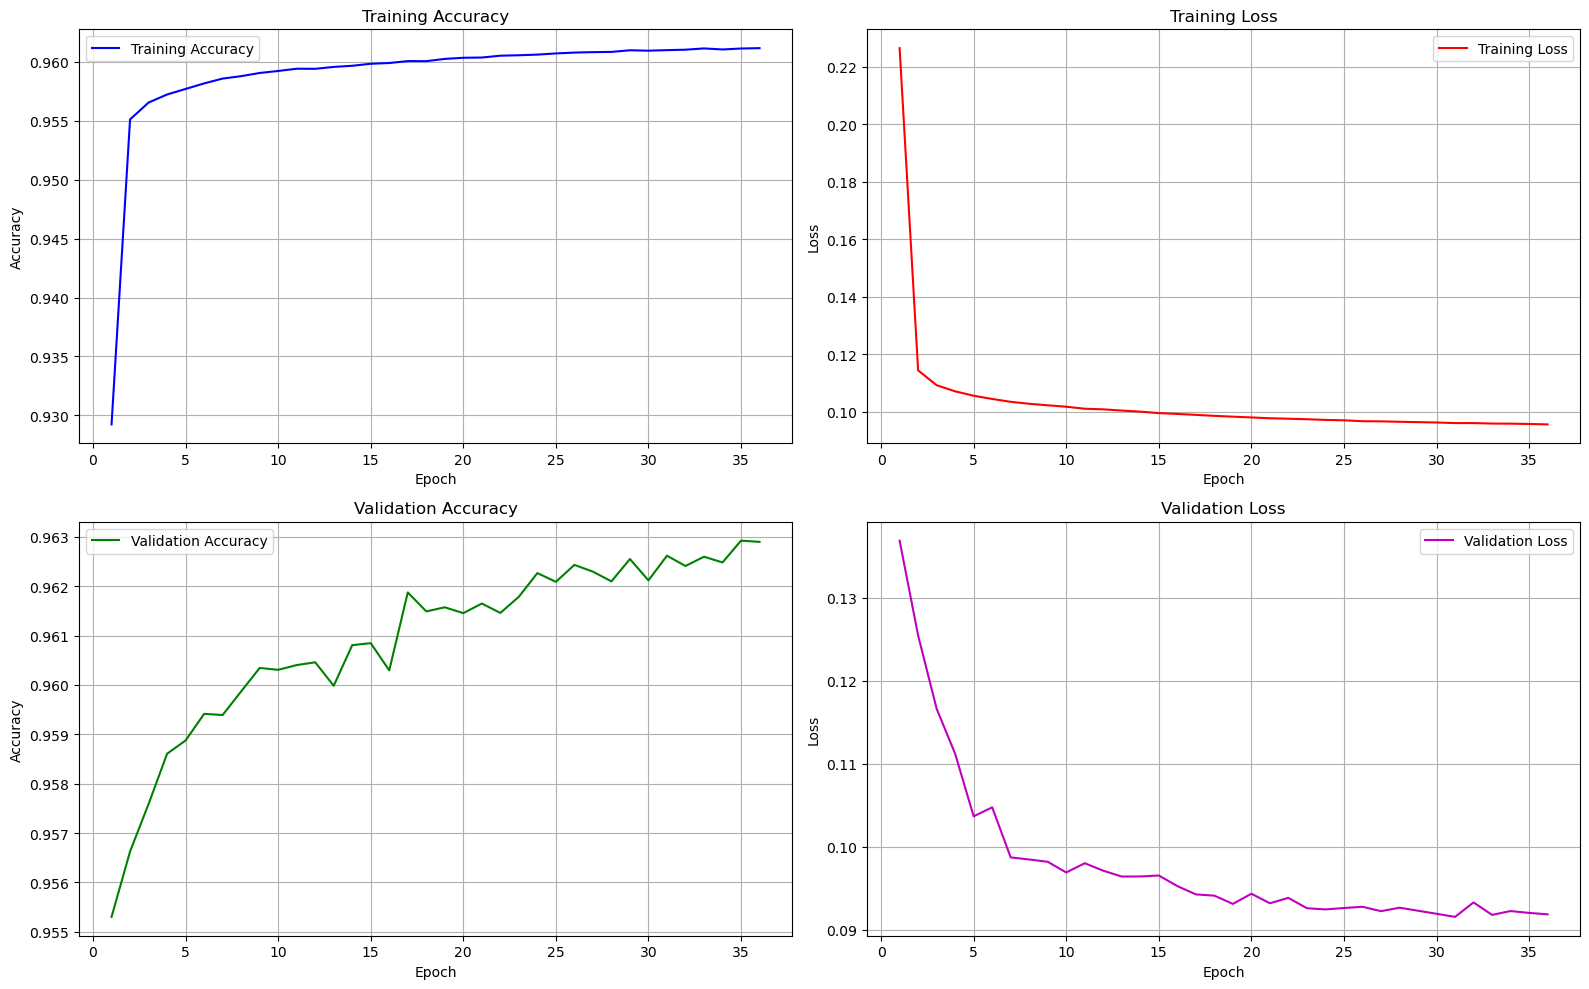

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_df = pd.read_csv(log_name)  # Đổi tên file nếu cần

epochs = range(1, len(log_df) + 1)

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
#plt.ylim(0.40, 1.0)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
#plt.ylim(0.95, 1.0)

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Đã lưu biểu đồ vào file: log_mono/resource_usage_plot_vertical.png


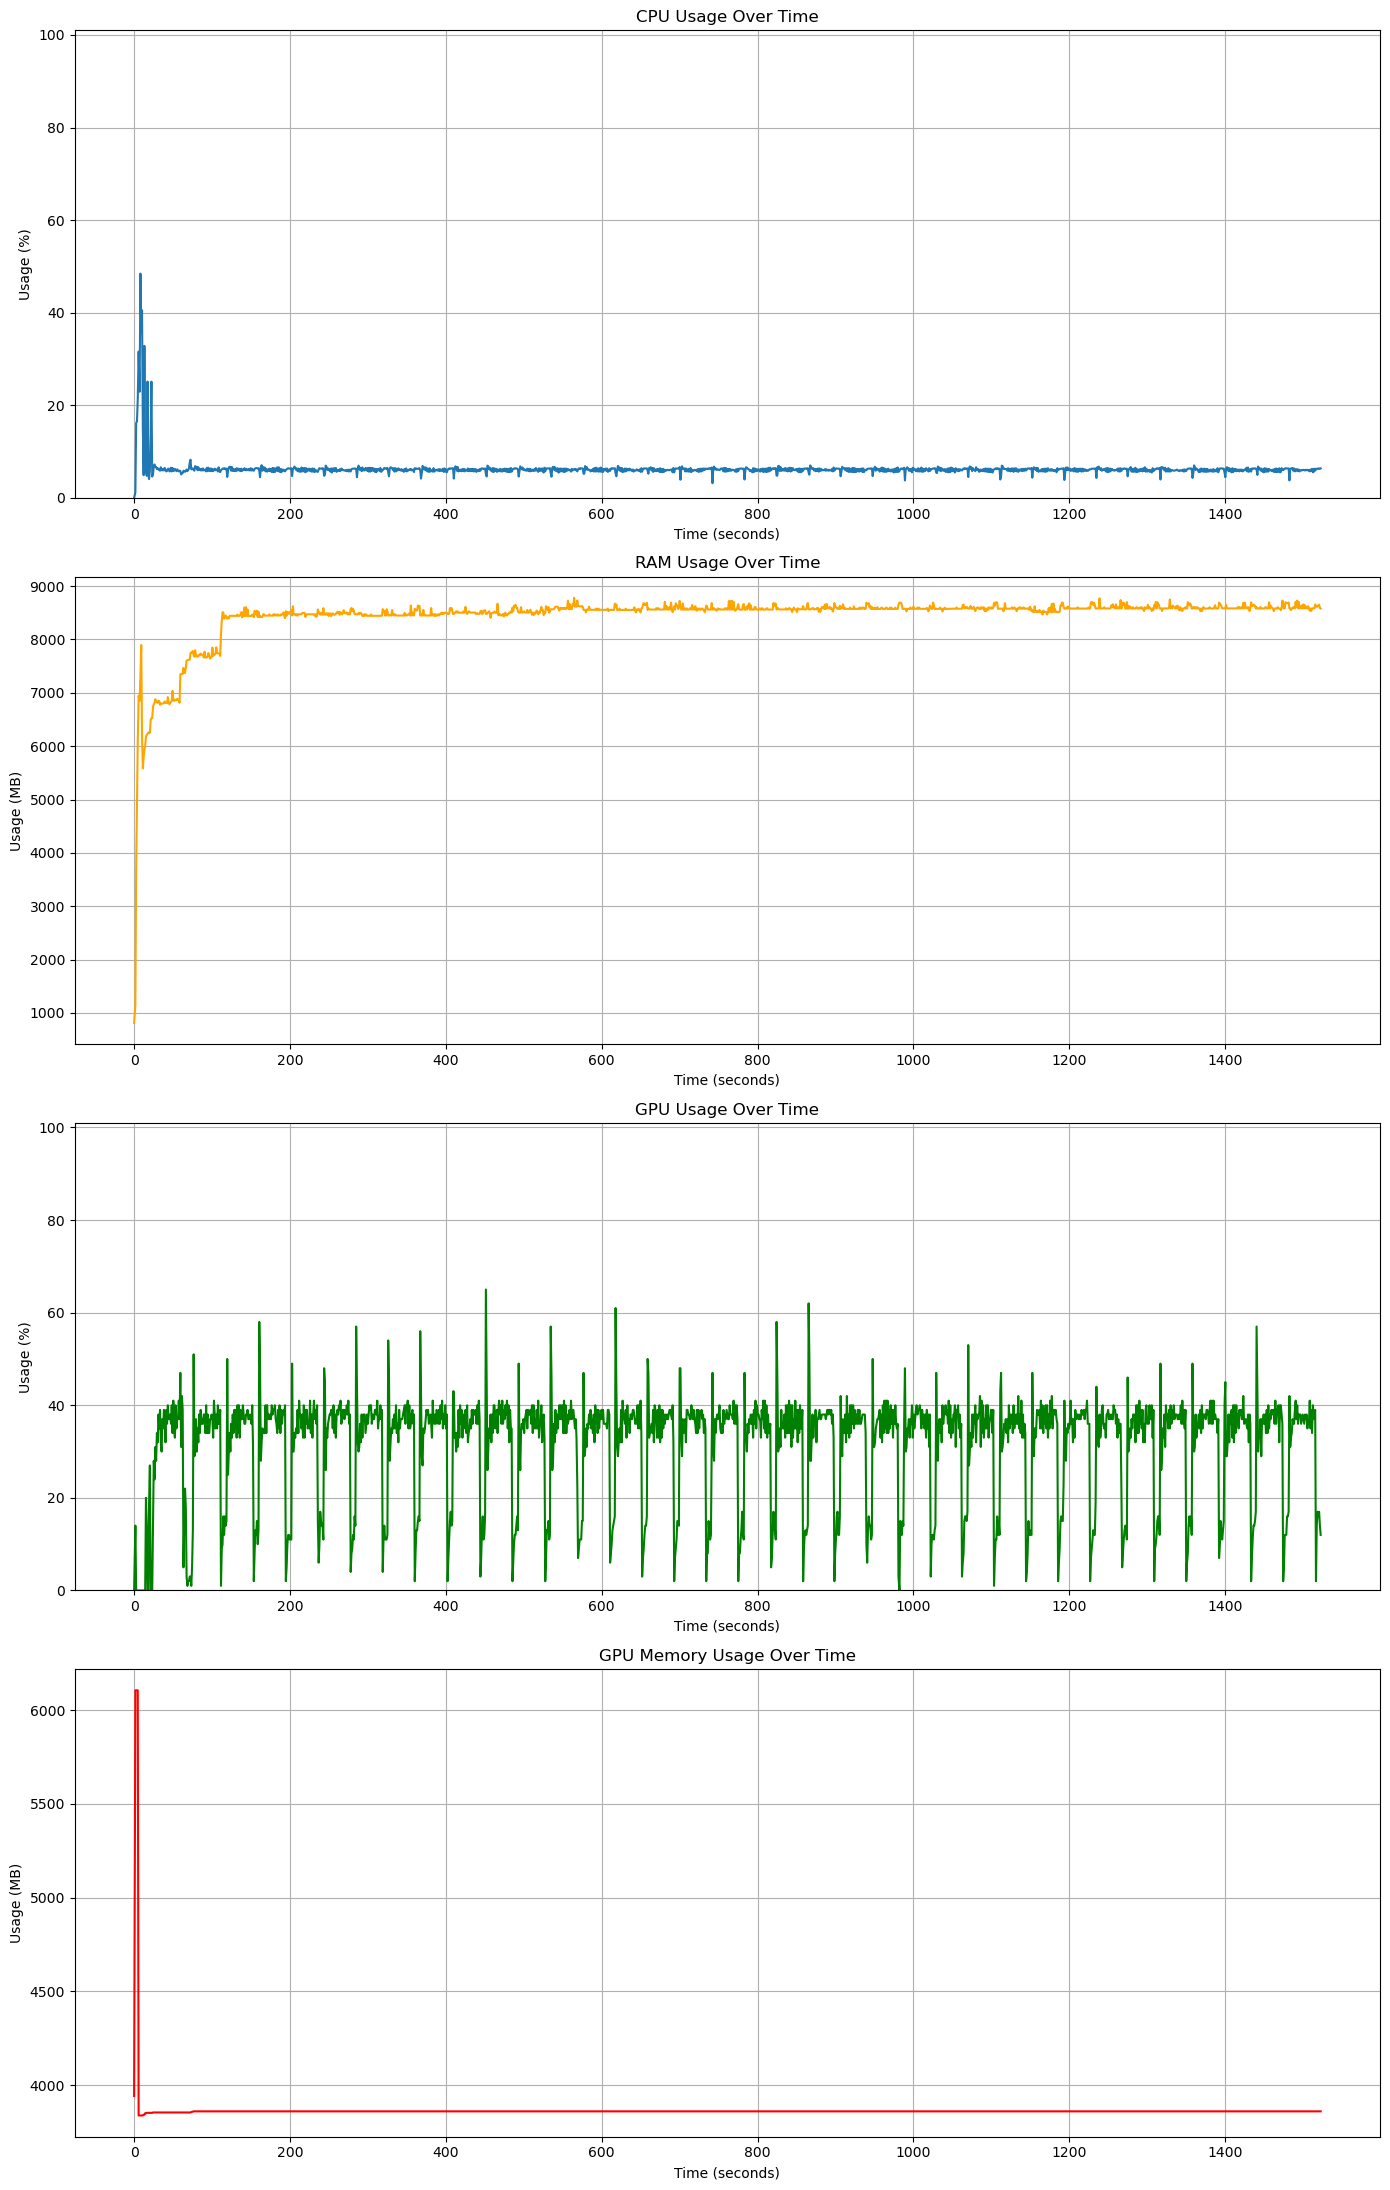

In [10]:
df = pd.read_csv(resource_usage)

# Tính toán thời gian đã trôi qua (tính bằng giây) từ lúc bắt đầu
df['elapsed_time'] = df['timestamp'] - df['timestamp'].iloc[0]  # Corrected iloc

# Tạo một figure lớn hơn
fig = plt.figure(figsize=(14, 22))  # Tăng chiều cao figure

# 1. Biểu đồ CPU Usage
ax1 = fig.add_subplot(4, 1, 1)  # 4 hàng, 1 cột, vị trí 1
ax1.plot(df['elapsed_time'], df['cpu_usage'], label='CPU Usage')
ax1.set_title('CPU Usage Over Time')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Usage (%)')
ax1.grid(True)
ax1.set_ylim(0, 101)

# 2. Biểu đồ RAM Usage
ax2 = fig.add_subplot(4, 1, 2)  # 4 hàng, 1 cột, vị trí 2
ax2.plot(df['elapsed_time'], df['ram_usage_mb'], color='orange', label='RAM Usage')
ax2.set_title('RAM Usage Over Time')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Usage (MB)')
ax2.grid(True)

# 3. Biểu đồ GPU Usage
ax3 = fig.add_subplot(4, 1, 3)  # 4 hàng, 1 cột, vị trí 3
ax3.plot(df['elapsed_time'], df['gpu_usage'], color='green', label='GPU Usage')
ax3.set_title('GPU Usage Over Time')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Usage (%)')
ax3.grid(True)
ax3.set_ylim(0, 101)

# 4. Biểu đồ GPU Memory Usage
ax4 = fig.add_subplot(4, 1, 4)  # 4 hàng, 1 cột, vị trí 4
ax4.plot(df['elapsed_time'], df['gpu_mem_usage_mb'], color='red', label='GPU Memory Usage')
ax4.set_title('GPU Memory Usage Over Time')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Usage (MB)')
ax4.grid(True)

# Điều chỉnh layout để tránh các tiêu đề và nhãn bị chồng lên nhau
plt.tight_layout()

# Lưu biểu đồ thành file ảnh
output_image_path = os.path.join(
    os.path.dirname(resource_usage),
    'resource_usage_plot_vertical.png'
)
plt.savefig(output_image_path)
print(f"Đã lưu biểu đồ vào file: {output_image_path}")

# Hiển thị biểu đồ
plt.show()